In [ ]:
#   Tema projekta:
#       Procena vrednosti fudbalera sa Transfermarkt-a primenom regresionih modela
#   Deo projekta:
#       Kreiranje i upotreba regresionih modela
#   Autori:
#       Miloš Sirar, IN 3/2020, sirar.in3.2020@uns.ac.rs
#       Vasilije Zeković, IN 4/2020, zekovic.in4.2020@uns.ac.rs
#   Predmet: 
#       Mašinsko učenje 1
#   Profesor:
#       Tatjana Lončar-Turukalo
#   Asistenti:
#       Tijana Nosek
#       Ivan Lazić

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import datasets
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [2]:
df_all = pd.read_csv("all_data_new_3.csv")

In [3]:
df_all

,valuation_date,height_in_cm,market_value_on_valuation_date,games_played_in_domestic_competition_on_valuation_date,average_minutes_in_domestic_competition_on_valuation_date,goals_in_domestic_competition_on_valuation_date,assists_in_domestic_competition_on_valuation_date,yellow_cards_in_domestic_competition_on_valuation_date,red_cards_in_domestic_competition_on_valuation_date,games_played_in_european_competition_on_valuation_date,...,sub_position_Goalkeeper,sub_position_Left Midfield,sub_position_Left Winger,sub_position_Left-Back,sub_position_Right Midfield,sub_position_Right Winger,sub_position_Right-Back,sub_position_Second Striker,foot_left,foot_right
0,3,175.0,17000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,4,175.0,18000000,18.0,69.000000,1.0,3.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,6,175.0,15000000,21.0,43.000000,1.0,3.0,3.0,0.0,5.0,...,0,0,0,0,0,0,0,0,0,1
3,7,175.0,14000000,15.0,52.866667,0.0,4.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,9,175.0,14000000,24.0,59.333333,4.0,7.0,2.0,0.0,6.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41868,28,192.0,1200000,3.0,86.666667,0.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
41869,29,192.0,2200000,9.0,88.666667,3.0,0.0,5.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
41870,30,192.0,3000000,11.0,84.000000,2.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
41871,30,192.0,2500000,13.0,89.538462,0.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
x = df_all.drop(["market_value_on_valuation_date"], axis = 1)
y = df_all["market_value_on_valuation_date"]

In [5]:
def model_evaluation(y_test, y_predicted, N, d):
    mse = np.mean((y_test-y_predicted)**2)
    # mse = mean_squared_error(y_test,y_predicted)
    mae = np.mean(np.abs(y_test-y_predicted))
    # mae = mean_absolute_error(y_test,y_predicted)
    rmse = np.sqrt(mse)
    r2 = 1-np.sum((y_test-y_predicted)**2)/np.sum((y_test-np.mean(y_test))**2)
    # r2 = r2_score(y_test, y_predicted)
    r2_adj = 1-((1-r2)*(N-1))/(N-d-1)

    # printing values
    print('Mean squared error: ', mse)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    print('R2 score: ', r2)
    print('R2 adjusted score: ', r2_adj)

    # Uporedni prikaz nekoliko pravih i predvidjenih vrednosti
    res=pd.concat([pd.DataFrame(y_test.values), pd.DataFrame(y_predicted)], axis=1)
    res.columns = ['y', 'y_pred']
    print(res.head(20))
    return mse,mae,rmse,r2,r2_adj

In [6]:
def standardizacija(x_train, x_test):
  cols = x_train.columns
  s = StandardScaler()
  s.fit(x_train.iloc[:, :19])
  x_train_std = s.transform(x_train.iloc[:, :19])
  x_test_std = s.transform(x_test.iloc[:, :19])
  x_train_std = pd.DataFrame(x_train_std)
  x_test_std = pd.DataFrame(x_test_std)

  x_train_std = pd.concat([x_train_std, x_train.iloc[:, 19:].reset_index(drop=True)], axis=1)
  x_test_std = pd.concat([x_test_std, x_test.iloc[:, 19:].reset_index(drop=True)], axis=1)

  x_train_std.columns = list(cols)
  x_test_std.columns = list(cols)
  return x_train_std, x_test_std

In [7]:
def plot_coefficients(subplot_coefficients = [], n_splits = 5):
    plt.figure(figsize=(10, 2 * n_splits))

    for idx in range(n_splits):
        plt.subplot(n_splits, 1, idx+1)
        plt.bar(range(len(subplot_coefficients[idx])), subplot_coefficients[idx], label=f'Fold {idx+1}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42) # ovde 10, dole ne bi trebalo nista
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)


In [9]:
# Unakrsna validacija

# Podela skupa podataka na trening i test, a potom podela trening skupa na 5 disjunktnih podskupova, 
# te realizacija unakrsne validacije kroz petlju u kojoj se radi.

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error # mera uspesnosti koju cemo koristiti

kf = KFold(n_splits=5) 
# kf = KFold(n_splits=5, shuffle=False)
indexes = kf.split(x_train, y_train)
indexes = list(indexes) # jer se u pythonu generator stvori za samo jedno iteriranje

In [10]:
# PCA - Principal Component Analysis 

from sklearn.decomposition import PCA

# obavezna standardizacija
x_train_std, x_test_std = standardizacija(x_train, x_test)

In [11]:
x_train_std

,valuation_date,height_in_cm,games_played_in_domestic_competition_on_valuation_date,average_minutes_in_domestic_competition_on_valuation_date,goals_in_domestic_competition_on_valuation_date,assists_in_domestic_competition_on_valuation_date,yellow_cards_in_domestic_competition_on_valuation_date,red_cards_in_domestic_competition_on_valuation_date,games_played_in_european_competition_on_valuation_date,average_minutes_in_european_competition_on_valuation_date,...,sub_position_Goalkeeper,sub_position_Left Midfield,sub_position_Left Winger,sub_position_Left-Back,sub_position_Right Midfield,sub_position_Right Winger,sub_position_Right-Back,sub_position_Second Striker,foot_left,foot_right
0,0.078930,1.304077,-0.649815,0.071876,-0.417833,-0.458709,-0.618111,-0.143054,0.171972,0.082639,...,0,0,0,0,0,0,0,0,1,0
1,0.795558,0.270356,-0.940443,-1.143670,-0.417833,-0.458709,-0.618111,-0.143054,-0.429993,-0.478246,...,0,0,0,0,0,0,0,0,0,1
2,0.676120,-1.797087,0.512695,0.908066,-0.417833,2.885866,1.463154,-0.143054,-0.429993,-0.478246,...,0,0,0,1,0,0,0,0,1,0
3,-0.159946,-0.468017,0.367381,1.251803,3.099919,-0.458709,-0.618111,-0.143054,-0.429993,-0.478246,...,0,0,0,0,0,0,0,0,0,1
4,0.198368,0.270356,-0.795129,1.260708,-0.417833,-0.458709,0.075644,-0.143054,-0.429993,-0.478246,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37680,0.198368,0.713379,-0.940443,-1.143670,-0.417833,-0.458709,-0.618111,-0.143054,-0.429993,-0.478246,...,0,0,0,0,0,0,0,0,1,0
37681,-0.518260,1.451752,0.658009,0.787118,0.754751,0.377435,-0.618111,-0.143054,-0.429993,-0.478246,...,0,0,0,0,0,0,0,0,1,0
37682,0.317806,1.156403,-0.940443,-1.143670,-0.417833,-0.458709,-0.618111,-0.143054,-0.429993,-0.478246,...,1,0,0,0,0,0,0,0,0,1
37683,-1.234887,-0.911040,1.093950,1.216818,3.686211,7.902727,0.075644,-0.143054,1.375901,1.996249,...,0,0,0,0,0,0,0,0,0,0


In [12]:
x_train_std

,valuation_date,height_in_cm,games_played_in_domestic_competition_on_valuation_date,average_minutes_in_domestic_competition_on_valuation_date,goals_in_domestic_competition_on_valuation_date,assists_in_domestic_competition_on_valuation_date,yellow_cards_in_domestic_competition_on_valuation_date,red_cards_in_domestic_competition_on_valuation_date,games_played_in_european_competition_on_valuation_date,average_minutes_in_european_competition_on_valuation_date,...,sub_position_Goalkeeper,sub_position_Left Midfield,sub_position_Left Winger,sub_position_Left-Back,sub_position_Right Midfield,sub_position_Right Winger,sub_position_Right-Back,sub_position_Second Striker,foot_left,foot_right
0,0.078930,1.304077,-0.649815,0.071876,-0.417833,-0.458709,-0.618111,-0.143054,0.171972,0.082639,...,0,0,0,0,0,0,0,0,1,0
1,0.795558,0.270356,-0.940443,-1.143670,-0.417833,-0.458709,-0.618111,-0.143054,-0.429993,-0.478246,...,0,0,0,0,0,0,0,0,0,1
2,0.676120,-1.797087,0.512695,0.908066,-0.417833,2.885866,1.463154,-0.143054,-0.429993,-0.478246,...,0,0,0,1,0,0,0,0,1,0
3,-0.159946,-0.468017,0.367381,1.251803,3.099919,-0.458709,-0.618111,-0.143054,-0.429993,-0.478246,...,0,0,0,0,0,0,0,0,0,1
4,0.198368,0.270356,-0.795129,1.260708,-0.417833,-0.458709,0.075644,-0.143054,-0.429993,-0.478246,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37680,0.198368,0.713379,-0.940443,-1.143670,-0.417833,-0.458709,-0.618111,-0.143054,-0.429993,-0.478246,...,0,0,0,0,0,0,0,0,1,0
37681,-0.518260,1.451752,0.658009,0.787118,0.754751,0.377435,-0.618111,-0.143054,-0.429993,-0.478246,...,0,0,0,0,0,0,0,0,1,0
37682,0.317806,1.156403,-0.940443,-1.143670,-0.417833,-0.458709,-0.618111,-0.143054,-0.429993,-0.478246,...,1,0,0,0,0,0,0,0,0,1
37683,-1.234887,-0.911040,1.093950,1.216818,3.686211,7.902727,0.075644,-0.143054,1.375901,1.996249,...,0,0,0,0,0,0,0,0,0,0


In [13]:
x_train

,valuation_date,height_in_cm,games_played_in_domestic_competition_on_valuation_date,average_minutes_in_domestic_competition_on_valuation_date,goals_in_domestic_competition_on_valuation_date,assists_in_domestic_competition_on_valuation_date,yellow_cards_in_domestic_competition_on_valuation_date,red_cards_in_domestic_competition_on_valuation_date,games_played_in_european_competition_on_valuation_date,average_minutes_in_european_competition_on_valuation_date,...,sub_position_Goalkeeper,sub_position_Left Midfield,sub_position_Left Winger,sub_position_Left-Back,sub_position_Right Midfield,sub_position_Right Winger,sub_position_Right-Back,sub_position_Second Striker,foot_left,foot_right
18080,23,192.0,2.0,45.500000,0.0,0.0,0.0,0.0,1.0,17.0,...,0,0,0,0,0,0,0,0,1,0
32164,29,185.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
23717,28,171.0,10.0,76.800000,0.0,4.0,3.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
20046,21,180.0,9.0,89.666667,6.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
14922,24,185.0,1.0,90.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,24,188.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
11284,18,193.0,11.0,72.272727,2.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
38158,25,191.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
860,12,177.0,14.0,88.357143,7.0,10.0,1.0,0.0,3.0,75.0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
x.columns.shape

(35,)

In [15]:
pca = PCA(n_components = 0.95) # udeo varijanse
pca.fit(x_train_std)
x_train_pca = pca.transform(x_train_std)
x_test_pca = pca.transform(x_test_std)

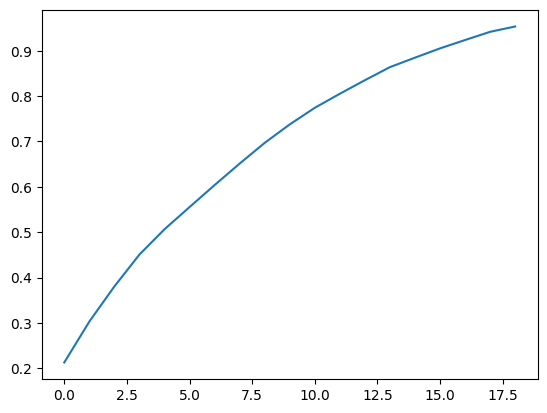

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)) # Udeo objasnjene varijanse po komponenti

In [17]:
x_train_std.shape

(37685, 35)

In [18]:
x_train_pca.shape

(37685, 19)

In [19]:
pca = PCA(n_components = 20) # broj komponenti
pca.fit(x_train_std)
x_train_pca = pca.transform(x_train_std)
x_test_pca = pca.transform(x_test_std)

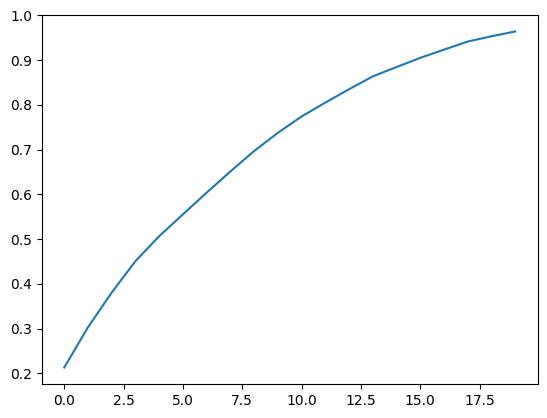

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)) # Udeo objasnjene varijanse po komponenti

In [21]:
# dosta dobra redukcija
pca = PCA(n_components = 0.99) # udeo varijanse
pca.fit(x_train_std)
x_train_pca = pca.transform(x_train_std)
x_test_pca = pca.transform(x_test_std)

In [22]:
y_train

18080     9000000
32164     2000000
23717    22000000
20046    10000000
14922     1000000
           ...   
6265      3200000
11284    25000000
38158     2300000
860      28000000
15795     8000000
Name: market_value_on_valuation_date, Length: 37685, dtype: int64

In [23]:
x_train_std

,valuation_date,height_in_cm,games_played_in_domestic_competition_on_valuation_date,average_minutes_in_domestic_competition_on_valuation_date,goals_in_domestic_competition_on_valuation_date,assists_in_domestic_competition_on_valuation_date,yellow_cards_in_domestic_competition_on_valuation_date,red_cards_in_domestic_competition_on_valuation_date,games_played_in_european_competition_on_valuation_date,average_minutes_in_european_competition_on_valuation_date,...,sub_position_Goalkeeper,sub_position_Left Midfield,sub_position_Left Winger,sub_position_Left-Back,sub_position_Right Midfield,sub_position_Right Winger,sub_position_Right-Back,sub_position_Second Striker,foot_left,foot_right
0,0.078930,1.304077,-0.649815,0.071876,-0.417833,-0.458709,-0.618111,-0.143054,0.171972,0.082639,...,0,0,0,0,0,0,0,0,1,0
1,0.795558,0.270356,-0.940443,-1.143670,-0.417833,-0.458709,-0.618111,-0.143054,-0.429993,-0.478246,...,0,0,0,0,0,0,0,0,0,1
2,0.676120,-1.797087,0.512695,0.908066,-0.417833,2.885866,1.463154,-0.143054,-0.429993,-0.478246,...,0,0,0,1,0,0,0,0,1,0
3,-0.159946,-0.468017,0.367381,1.251803,3.099919,-0.458709,-0.618111,-0.143054,-0.429993,-0.478246,...,0,0,0,0,0,0,0,0,0,1
4,0.198368,0.270356,-0.795129,1.260708,-0.417833,-0.458709,0.075644,-0.143054,-0.429993,-0.478246,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37680,0.198368,0.713379,-0.940443,-1.143670,-0.417833,-0.458709,-0.618111,-0.143054,-0.429993,-0.478246,...,0,0,0,0,0,0,0,0,1,0
37681,-0.518260,1.451752,0.658009,0.787118,0.754751,0.377435,-0.618111,-0.143054,-0.429993,-0.478246,...,0,0,0,0,0,0,0,0,1,0
37682,0.317806,1.156403,-0.940443,-1.143670,-0.417833,-0.458709,-0.618111,-0.143054,-0.429993,-0.478246,...,1,0,0,0,0,0,0,0,0,1
37683,-1.234887,-0.911040,1.093950,1.216818,3.686211,7.902727,0.075644,-0.143054,1.375901,1.996249,...,0,0,0,0,0,0,0,0,0,0


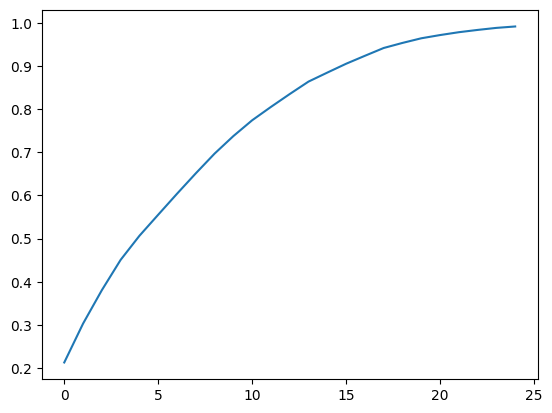

In [24]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)) # Udeo objasnjene varijanse po komponenti

In [25]:
x_train_std.shape

(37685, 35)

In [26]:
x_train_pca.shape

(37685, 25)

In [27]:
x_train_pca = pd.DataFrame(x_train_pca, columns=pca.get_feature_names_out(), index=y_train.index)
x_test_pca = pd.DataFrame(x_test_pca, columns=pca.get_feature_names_out(), index=y_test.index)

In [28]:
x_train_pca

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24
18080,0.825286,0.259374,-2.553987,-1.050307,1.180450,-0.830193,0.351559,0.209768,-1.161730,0.308639,...,0.746664,0.838496,2.193286,-0.198801,0.041685,0.101066,-1.133756,0.441877,-0.227627,0.233276
32164,-1.476395,0.142383,-0.424406,-1.334522,0.400558,-0.258164,0.290643,0.310805,-0.489949,0.490208,...,-0.020075,-0.120363,-0.473688,-0.550266,-0.710579,-0.044489,0.165826,0.090941,-0.472941,0.059414
23717,1.305978,-1.713143,1.139854,0.685665,-1.874970,2.047912,-0.672061,-0.885148,0.420723,1.661864,...,-0.816788,0.697350,0.786580,-0.107873,0.666621,0.262516,0.069512,0.160368,-0.059711,-0.630448
20046,0.539794,-0.901357,1.630351,-0.879409,-0.095951,-1.055252,0.314014,-0.297219,0.359228,0.515036,...,0.974858,-0.624520,-0.270113,-0.362672,0.099560,0.334704,-0.281427,0.183327,-0.103655,-0.205089
14922,-0.474266,-0.206793,-0.452531,-0.737500,-0.410227,-0.233034,0.171224,-0.050860,-0.457319,0.585987,...,-0.457415,0.587756,1.220808,-0.901454,0.120640,0.650008,-0.137222,0.148285,0.161340,0.210410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,-1.727048,0.411730,-0.140480,-0.632653,0.275595,-0.796337,0.285145,0.110341,-0.069416,0.451382,...,-0.229833,1.169001,-0.220690,0.075084,0.242603,-0.002298,-0.805144,0.370733,-0.193217,0.061317
11284,-0.095074,-0.261357,0.909025,0.032391,0.457457,-1.100220,0.205424,-0.294910,0.167546,0.040532,...,-0.674243,0.674969,0.732042,-0.148752,-0.750027,-0.066763,0.049829,0.253831,0.240371,0.267794
38158,-1.770455,0.337098,-0.379122,-0.520474,0.845017,-1.264617,0.448980,0.163201,-0.311743,0.543383,...,-0.222498,-0.032382,-0.444705,0.310943,0.599776,-0.013425,0.712017,-0.081761,0.005319,-0.158132
860,7.260295,1.733655,4.875929,-1.827270,0.620768,0.041365,-1.033680,-0.899728,3.356438,-2.055355,...,-0.935821,0.219081,0.134537,-1.833411,-0.072200,-0.197532,0.632639,-0.260495,-0.388996,-0.102072


In [29]:
x_test_pca

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24
216,0.507662,1.226553,-3.117802,-1.513649,-0.770122,1.663161,-0.720850,-0.243202,0.705829,0.041660,...,1.145634,1.276520,0.141653,-0.379781,0.499961,-1.059584,0.209507,0.297636,0.038087,-0.501970
9861,-0.338673,-0.837967,0.447186,-0.124241,1.620102,1.606331,-0.449381,0.173353,-0.256489,-1.678900,...,0.040815,-0.168883,0.044497,-0.503166,0.019155,0.255302,0.359720,0.060588,-0.544874,0.010340
14424,-0.206951,-1.210961,-0.340169,1.223170,-0.216005,0.299859,-0.340889,-0.460939,0.449150,-1.282056,...,0.223094,-0.670228,0.329769,0.059510,0.164984,0.134150,0.146819,0.652958,-0.021242,0.480044
5775,1.546540,1.667609,-2.162771,-1.530707,0.307200,0.334846,0.172663,0.441672,-1.589137,0.397601,...,0.795281,-0.257134,0.311568,0.000538,-0.897632,-0.193821,0.247812,0.080324,-0.465065,0.037233
20399,-1.427551,-0.424732,-0.854443,-0.994032,1.932985,-0.581802,0.246882,0.260582,-0.206976,0.156598,...,-0.040999,0.101988,-0.460149,0.172557,0.512015,-0.002152,0.668434,-0.115640,0.002475,-0.128415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25590,-2.208041,1.658476,1.371682,0.215456,-0.849081,-0.717239,0.376839,0.191985,-0.303905,-0.974928,...,0.324070,-0.271697,0.003526,0.339504,0.455106,0.011918,-0.730229,0.171929,-0.213787,-0.253701
11029,-0.466656,-0.439648,-0.318763,-1.780217,-0.604132,0.802672,0.066162,0.247405,-0.649537,0.462629,...,0.179990,-0.382814,-0.030022,0.310469,-0.305594,-0.252061,0.039473,-0.099139,0.197745,-0.177917
40508,0.437867,-1.459581,1.107752,1.115588,-0.154169,-2.010966,0.107027,6.078248,1.590651,1.035597,...,-0.105181,-0.392527,-0.186903,-0.720663,0.623557,0.587417,-0.598122,0.465714,-0.203166,-0.056419
8249,-0.139195,0.086208,2.419929,-0.020001,-1.976934,-0.639450,0.448970,-0.124774,-0.459349,-0.462324,...,0.158673,-0.539797,-0.099125,1.100176,0.111215,-0.463298,-0.590876,0.053871,-0.182610,-0.397205


In [124]:
# I model
# 1. slucaj, bez PCA

# Unakrsna validacija modela sa osnovnom hipotezom
# y = b0 + b1x1 + b2x2 + ... + bdxd
# Obuka modela u svakoj iteraciji u odnosu na trening skup iteracije
# Primena modela na uzorke iz test skupa
# Čuvanje MAE mere iz svake iteracije
# Računanje konačne prosečne MAE mere uspešnosti modela

MAE:  6324911.877922885
MAE:  6209735.796685829
MAE:  6178807.79834617
MAE:  6271557.291325149
MAE:  6307716.0759473825

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  6258545.768045483
Max coefficient:  2997421.465458905


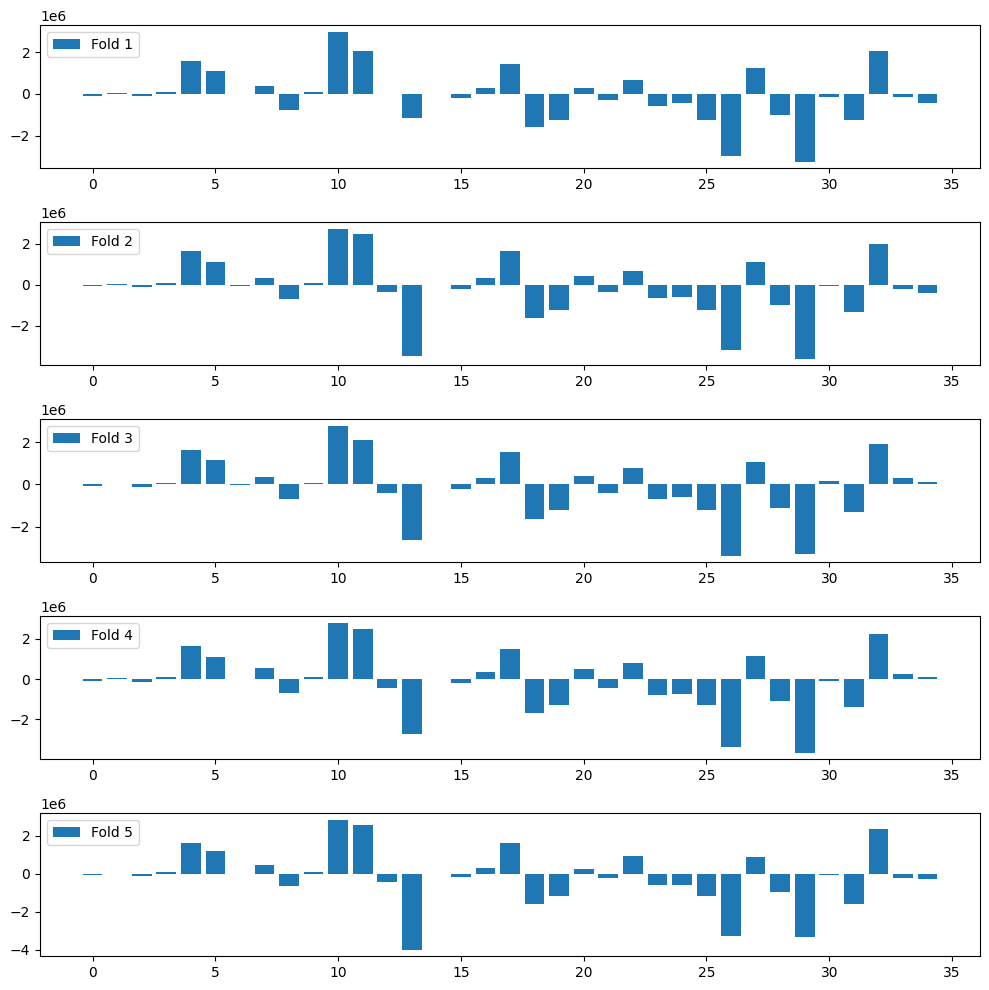

In [125]:
mae = []
subplot_coefficients = []

for train_index, test_index in indexes:
  x_train_i = x_train.iloc[train_index,:]
  x_test_i = x_train.iloc[test_index,:]
  y_train_i = y_train.iloc[train_index]
  y_test_i = y_train.iloc[test_index]

#   x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)
  regressor = LinearRegression(fit_intercept=True)
  regressor.fit(x_train_i, y_train_i)
  y_pred = regressor.predict(x_test_i)
  mae_i = mean_absolute_error(y_test_i, y_pred)

  print('MAE: ', mae_i)
  subplot_coefficients.append(regressor.coef_)

  mae.append(mae_i)


  coefficients = regressor.coef_


print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))
print("Max coefficient: ", np.max(subplot_coefficients[0]))
plot_coefficients(subplot_coefficients, 5)

In [126]:
max_coef_index = np.argmax(np.abs(coefficients))

most_significant_feature = x_train_i.columns[max_coef_index]

print(f"The most significant feature is: {most_significant_feature}")

The most significant feature is: red_cards_in_european_competition_on_valuation_date


In [127]:
x_train.columns

Index(['valuation_date', 'height_in_cm',
       'games_played_in_domestic_competition_on_valuation_date',
       'average_minutes_in_domestic_competition_on_valuation_date',
       'goals_in_domestic_competition_on_valuation_date',
       'assists_in_domestic_competition_on_valuation_date',
       'yellow_cards_in_domestic_competition_on_valuation_date',
       'red_cards_in_domestic_competition_on_valuation_date',
       'games_played_in_european_competition_on_valuation_date',
       'average_minutes_in_european_competition_on_valuation_date',
       'goals_in_european_competition_on_valuation_date',
       'assists_in_european_competition_on_valuation_date',
       'yellow_cards_in_european_competition_on_valuation_date',
       'red_cards_in_european_competition_on_valuation_date',
       'club_value_on_valuation_year', 'old', 'citizienship_tier',
       'club_domestic_competition_on_valuation_date_tier', 'position_Defender',
       'position_Goalkeeper', 'position_Midfield',
     

In [128]:
x_train

,valuation_date,height_in_cm,games_played_in_domestic_competition_on_valuation_date,average_minutes_in_domestic_competition_on_valuation_date,goals_in_domestic_competition_on_valuation_date,assists_in_domestic_competition_on_valuation_date,yellow_cards_in_domestic_competition_on_valuation_date,red_cards_in_domestic_competition_on_valuation_date,games_played_in_european_competition_on_valuation_date,average_minutes_in_european_competition_on_valuation_date,...,sub_position_Goalkeeper,sub_position_Left Midfield,sub_position_Left Winger,sub_position_Left-Back,sub_position_Right Midfield,sub_position_Right Winger,sub_position_Right-Back,sub_position_Second Striker,foot_left,foot_right
18080,23,192.0,2.0,45.500000,0.0,0.0,0.0,0.0,1.0,17.0,...,0,0,0,0,0,0,0,0,1,0
32164,29,185.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
23717,28,171.0,10.0,76.800000,0.0,4.0,3.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
20046,21,180.0,9.0,89.666667,6.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
14922,24,185.0,1.0,90.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,24,188.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
11284,18,193.0,11.0,72.272727,2.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
38158,25,191.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
860,12,177.0,14.0,88.357143,7.0,10.0,1.0,0.0,3.0,75.0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
regressor

LinearRegression()

In [130]:
# promena hiperparametra

mae = []
for train_index, test_index in indexes:
  x_train_i = x_train.iloc[train_index,:]
  x_test_i = x_train.iloc[test_index,:]
  y_train_i = y_train.iloc[train_index]
  y_test_i = y_train.iloc[test_index]

#   x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)
  regressor = LinearRegression(fit_intercept=False) # promena hiperparametra
  regressor.fit(x_train_i, y_train_i)
  y_pred = regressor.predict(x_test_i)
  mae_i = mean_absolute_error(y_test_i, y_pred)
  print('MAE: ', mae_i)
  mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  6324911.868638953
MAE:  6209735.780288939
MAE:  6178807.7878391165
MAE:  6271557.285640879


MAE:  6307716.060114438

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  6258545.756504466


In [131]:
# I model
# 2. slucaj, sa PCA

# Unakrsna validacija modela sa osnovnom hipotezom
# y = b0 + b1x1 + b2x2 + ... + bdxd
# Obuka modela u svakoj iteraciji u odnosu na trening skup iteracije
# Primena modela na uzorke iz test skupa
# Čuvanje MAE mere iz svake iteracije
# Računanje konačne prosečne MAE mere uspešnosti modela

In [132]:
mae = []
for train_index, test_index in indexes:
  x_train_pca_i = x_train_pca.iloc[train_index,:]
  x_test_pca_i = x_train_pca.iloc[test_index,:]
  y_train_i = y_train.iloc[train_index]
  y_test_i = y_train.iloc[test_index]

  regressor = LinearRegression(fit_intercept=True)
  regressor.fit(x_train_pca_i, y_train_i)
  y_pred = regressor.predict(x_test_pca_i)
  mae_i = mean_absolute_error(y_test_i, y_pred)
  print('MAE: ', mae_i)
  mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  6310238.30133464
MAE:  6196440.411176602


MAE:  6171845.390113876
MAE:  6253346.574266048
MAE:  6300949.436651737

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  6246564.02270858


In [133]:
mae = []
for train_index, test_index in indexes:
  x_train_pca_i = x_train_pca.iloc[train_index,:]
  x_test_pca_i = x_train_pca.iloc[test_index,:]
  y_train_i = y_train.iloc[train_index]
  y_test_i = y_train.iloc[test_index]

  regressor = LinearRegression(fit_intercept=False) # promena hiperparametra
  regressor.fit(x_train_pca_i, y_train_i)
  y_pred = regressor.predict(x_test_pca_i)
  mae_i = mean_absolute_error(y_test_i, y_pred)
  print('MAE: ', mae_i)
  mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  11041933.309263825
MAE:  10805520.731002629
MAE:  10849012.343380967
MAE:  10932135.324397422
MAE:  10844395.464957956

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  10894599.434600558


In [134]:
# II model
# 1. slucaj, bez PCA

# Unakrsna validacija modela sa osnovnom hipotezom uz standardizaciju
# y = b0 + b1x1 + b2x2 + ... + bdxd
# Obuka modela u svakoj iteraciji u odnosu na trening skup iteracije
# Primena modela na uzorke iz test skupa
# Čuvanje MAE mere iz svake iteracije
# Računanje konačne prosečne MAE mere uspešnosti modela

In [135]:
mae = []
for train_index, test_index in indexes:
  x_train_i = x_train.iloc[train_index,:]
  x_test_i = x_train.iloc[test_index,:]
  y_train_i = y_train.iloc[train_index]
  y_test_i = y_train.iloc[test_index]

  x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)
  regressor = LinearRegression(fit_intercept=True) # promena hiperparametra
  regressor.fit(x_train_i, y_train_i)
  y_pred = regressor.predict(x_test_i)
  mae_i = mean_absolute_error(y_test_i, y_pred)
  print('MAE: ', mae_i)
  mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  6324911.877922885
MAE:  6209735.796685829
MAE:  6178807.79834617
MAE:  6271557.291325149
MAE:  6307716.0759473825

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  6258545.768045483


In [136]:
mae = []
for train_index, test_index in indexes:
  x_train_i = x_train.iloc[train_index,:]
  x_test_i = x_train.iloc[test_index,:]
  y_train_i = y_train.iloc[train_index]
  y_test_i = y_train.iloc[test_index]

  x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)
  regressor = LinearRegression(fit_intercept=False) # promena hiperparametra
  regressor.fit(x_train_i, y_train_i)
  y_pred = regressor.predict(x_test_i)
  mae_i = mean_absolute_error(y_test_i, y_pred)
  print('MAE: ', mae_i)
  mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  6324911.868638953
MAE:  6209735.780288939
MAE:  6178807.7878391165
MAE:  6271557.285640879
MAE:  6307716.060114438

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  6258545.756504466


In [137]:
# bez market_value_on_valuation_date
numeric_feats = ['height_in_cm',
       'games_played_in_domestic_competition_on_valuation_date',
       'average_minutes_in_domestic_competition_on_valuation_date',
       'goals_in_domestic_competition_on_valuation_date',
       'assists_in_domestic_competition_on_valuation_date',
       'yellow_cards_in_domestic_competition_on_valuation_date',
       'red_cards_in_domestic_competition_on_valuation_date',
       'games_played_in_european_competition_on_valuation_date',
       'average_minutes_in_european_competition_on_valuation_date',
       'goals_in_european_competition_on_valuation_date',
       'assists_in_european_competition_on_valuation_date',
       'yellow_cards_in_european_competition_on_valuation_date',
       'red_cards_in_european_competition_on_valuation_date',
       'club_value_on_valuation_year', 'old']

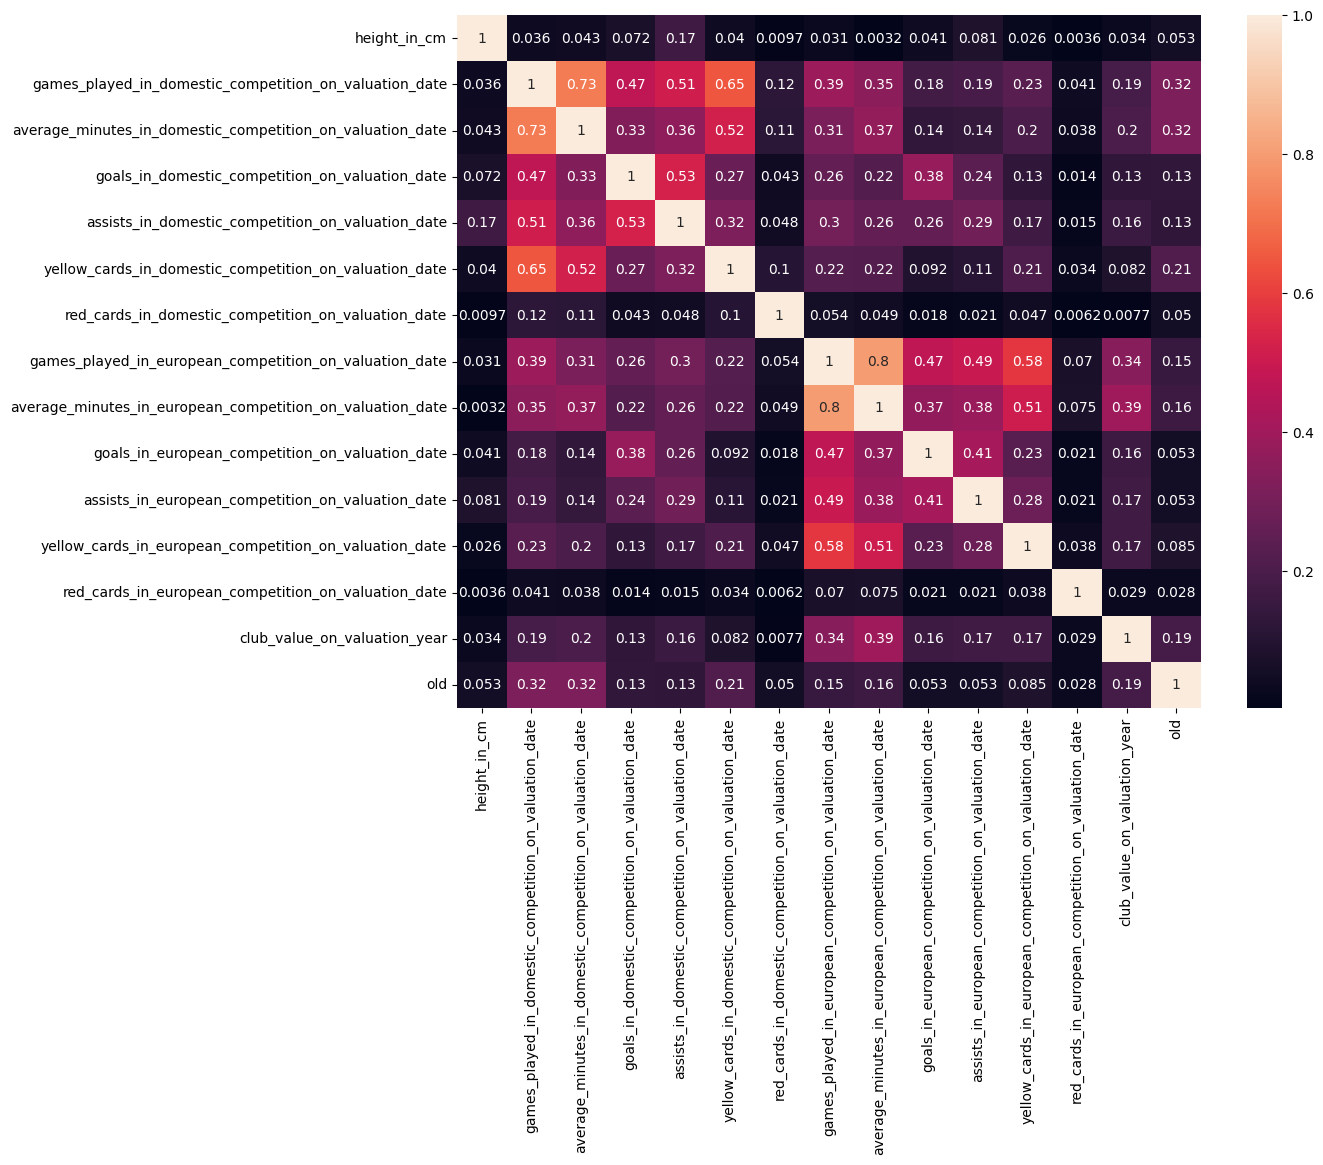

In [138]:
corr = x[numeric_feats].corr()
f = plt.figure(figsize=(12, 9))
sb.heatmap(corr.abs(), annot=True);

In [139]:
# III model, hipoteza sa interakcijama
# 1. slucaj, bez PCA

# y=b0+b1x1+b2x2+b3x3+...+bdxd+c1x1x2+c2x1x3+c3x2x3+...

MAE:  5117926.585644156
MAE:  5105032.137985936
MAE:  2588436941653029.0
MAE:  90400875031109.36
MAE:  5242918.659413559

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  535767566430003.1
Max coefficient:  1.0065495649266107e+18


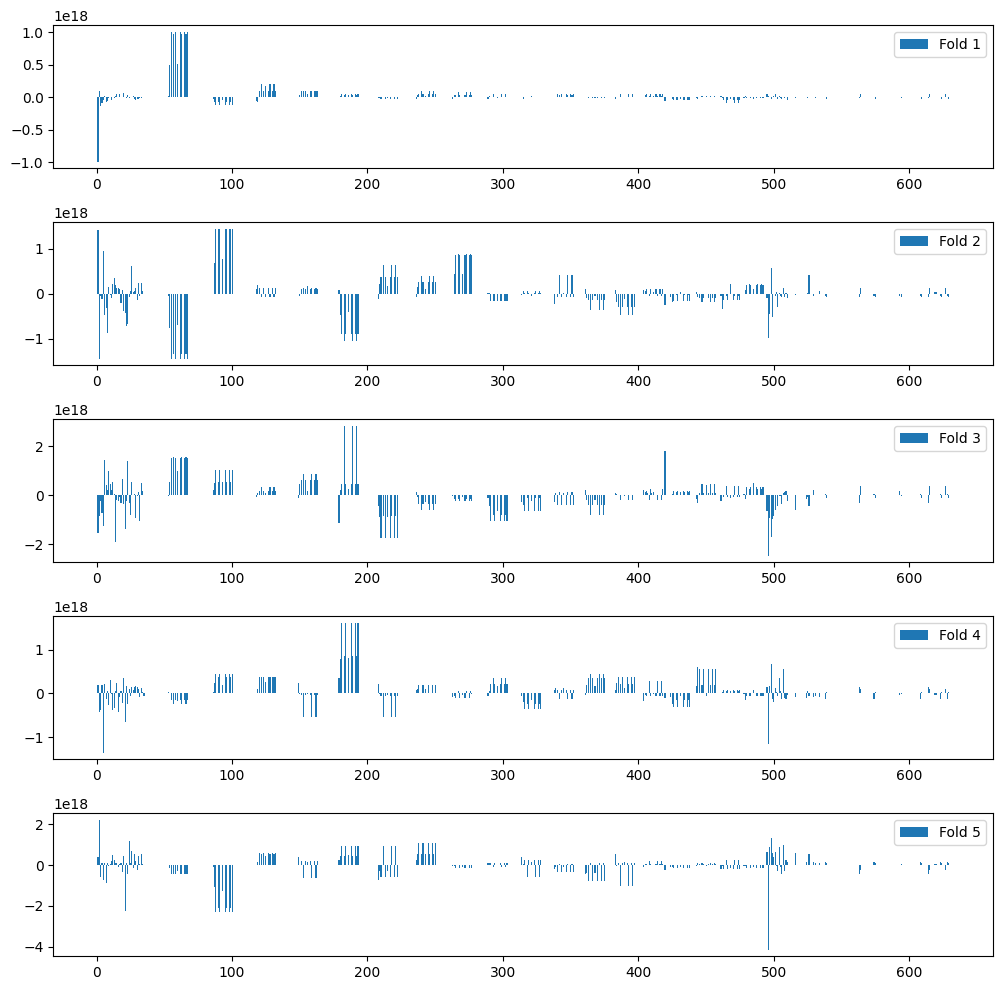

In [140]:
mae = []
subplot_coefficients = []

for train_index, test_index in indexes:
    x_train_i = x_train.iloc[train_index,:]
    x_test_i = x_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)

    poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=2)
    poly.fit(x_train_std_i)
    x_inter_train_i = poly.transform(x_train_std_i)
    x_inter_test_i = poly.transform(x_test_std_i)

    regressor = LinearRegression(fit_intercept=True) # izbor boljeg hiperparametra
    regressor.fit(x_inter_train_i, y_train_i)
    y_pred = regressor.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)

    print('MAE: ', mae_i)
    subplot_coefficients.append(regressor.coef_)

    mae.append(mae_i)


print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))
print("Max coefficient: ", np.max(subplot_coefficients[0]))
plot_coefficients(subplot_coefficients, 5)


In [141]:
mae = []
for train_index, test_index in indexes:
    x_train_i = x_train.iloc[train_index,:]
    x_test_i = x_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)

    poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=2)
    poly.fit(x_train_std_i)
    x_inter_train_i = poly.transform(x_train_std_i)
    x_inter_test_i = poly.transform(x_test_std_i)

    regressor = LinearRegression(fit_intercept=False) # izbor boljeg hiperparametra
    regressor.fit(x_inter_train_i, y_train_i)
    y_pred = regressor.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  5116554.637654239
MAE:  5091917.469550219
MAE:  1.0958115537432336e+16
MAE:  835765213075317.5
MAE:  5197695.065410641

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  2358776153182764.5


In [142]:
# smatramo da je ovo manje pravilno od slucaja odozgo, ali smo ga pokrenuli

# standardizacija
x_train_std, x_test_std = standardizacija(x_train, x_test)

poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=2)
poly.fit(x_train_std)
x_inter_train = poly.transform(x_train_std)
x_inter_test = poly.transform(x_test_std)

x_inter_train = pd.DataFrame(x_inter_train, columns=poly.get_feature_names_out(x_train.columns))
x_inter_test = pd.DataFrame(x_inter_test, columns=poly.get_feature_names_out(x_test.columns))

mae = []
for train_index, test_index in indexes:
    x_train_i = x_inter_train.iloc[train_index,:]
    x_test_i = x_inter_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    regressor = LinearRegression(fit_intercept=False) # izbor boljeg hiperparametra
    regressor.fit(x_train_i, y_train_i)
    y_pred = regressor.predict(x_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  5116121.300119411
MAE:  5088575.986201406
MAE:  1.2760606732280054e+16
MAE:  1139306064923057.2
MAE:  5202596.929282208

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  2779982562522081.0


In [143]:
# III model, hipoteza sa interakcijama
# 2. slucaj, sa PCA

# y=b0+b1x1+b2x2+b3x3+...+bdxd+c1x1x2+c2x1x3+c3x2x3+...

In [144]:
mae = []
for train_index, test_index in indexes:
    x_train_pca_i = x_train_pca.iloc[train_index,:]
    x_test_pca_i = x_train_pca.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=2) # izbor boljeg hiperparametra
    poly.fit(x_train_pca_i)
    x_inter_train_i = poly.transform(x_train_pca_i)
    x_inter_test_i = poly.transform(x_test_pca_i)

    regressor = LinearRegression(fit_intercept=True) # izbor boljeg hiperparametra
    regressor.fit(x_inter_train_i, y_train_i)
    y_pred = regressor.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  5215733.717326766
MAE:  5191628.021027341
MAE:  5223474.251899808
MAE:  5305360.022894979
MAE:  5261998.3900621245

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  5239638.880642204


In [145]:
mae = []
for train_index, test_index in indexes:
    x_train_pca_i = x_train_pca.iloc[train_index,:]
    x_test_pca_i = x_train_pca.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=2) # izbor boljeg hiperparametra
    poly.fit(x_train_pca_i)
    x_inter_train_i = poly.transform(x_train_pca_i)
    x_inter_test_i = poly.transform(x_test_pca_i)

    regressor = LinearRegression(fit_intercept=False) # izbor boljeg hiperparametra
    regressor.fit(x_inter_train_i, y_train_i)
    y_pred = regressor.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  5215733.717326771
MAE:  5191628.021027334
MAE:  5223474.251899813
MAE:  5305360.022894982
MAE:  5261998.390062136

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  5239638.880642207


In [146]:
# IV model, hipoteza sa interakcijama, i obelezjima drugog stepena
# 1. slucaj, bez PCA

# y=b0+b1x1+b2x2+b3x3+...+bdxd+c1x1x2+c2x1x3+c3x2x3+...

In [147]:
mae = []
for train_index, test_index in indexes:
    x_train_i = x_train.iloc[train_index,:]
    x_test_i = x_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)

    poly = PolynomialFeatures(interaction_only=False, include_bias=True, degree=2)
    poly.fit(x_train_std_i)
    x_inter_train_i = poly.transform(x_train_std_i)
    x_inter_test_i = poly.transform(x_test_std_i)

    regressor = LinearRegression(fit_intercept=True) # izbor boljeg hiperparametra
    regressor.fit(x_inter_train_i, y_train_i)
    y_pred = regressor.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  5123341.986682367
MAE:  5110667.950643492
MAE:  2332770036926.888
MAE:  23587242907451.234
MAE:  5198763.826323471

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  5184005675430.377


In [148]:
mae = []
for train_index, test_index in indexes:
    x_train_i = x_train.iloc[train_index,:]
    x_test_i = x_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)

    poly = PolynomialFeatures(interaction_only=False, include_bias=True, degree=2)
    poly.fit(x_train_std_i)
    x_inter_train_i = poly.transform(x_train_std_i)
    x_inter_test_i = poly.transform(x_test_std_i)

    regressor = LinearRegression(fit_intercept=False) # izbor boljeg hiperparametra
    regressor.fit(x_inter_train_i, y_train_i)
    y_pred = regressor.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  5123344.685027681
MAE:  5109017.967095661
MAE:  148600323581934.5
MAE:  5208334.8805835005
MAE:  5198818.326767294

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  29720068844290.07


In [149]:
# smatramo da je ovo manje pravilno od slucaja odozgo, ali smo ga pokrenuli

# standardizacija
x_train_std, x_test_std = standardizacija(x_train, x_test)

poly = PolynomialFeatures(interaction_only=False, include_bias=True, degree=2)
poly.fit(x_train_std)
x_inter_train = poly.transform(x_train_std)
x_inter_test = poly.transform(x_test_std)

x_inter_train = pd.DataFrame(x_inter_train, columns=poly.get_feature_names_out(x_train.columns))
x_inter_test = pd.DataFrame(x_inter_test, columns=poly.get_feature_names_out(x_test.columns))

mae = []
for train_index, test_index in indexes:
    x_train_i = x_inter_train.iloc[train_index,:]
    x_test_i = x_inter_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    regressor = LinearRegression(fit_intercept=False) # izbor boljeg hiperparametra
    regressor.fit(x_train_i, y_train_i)
    y_pred = regressor.predict(x_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  5124549.144752554
MAE:  5108673.9456417
MAE:  5135223.859627942
MAE:  5208330.61345564
MAE:  5200225.756667109

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  5155400.664028989


In [150]:
# IV model, hipoteza sa interakcijama, i obelezjima drugog stepena
# 2. slucaj, sa PCA

# y=b0+b1x1+b2x2+b3x3+...+bdxd+c1x1x2+c2x1x3+c3x2x3+...

MAE:  5151429.484410243
MAE:  5126569.146610057
MAE:  5161095.789784548
MAE:  5236240.418734244
MAE:  5210035.9070434915

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  5177074.149316517
Max coefficient:  8.715685002999115e+16


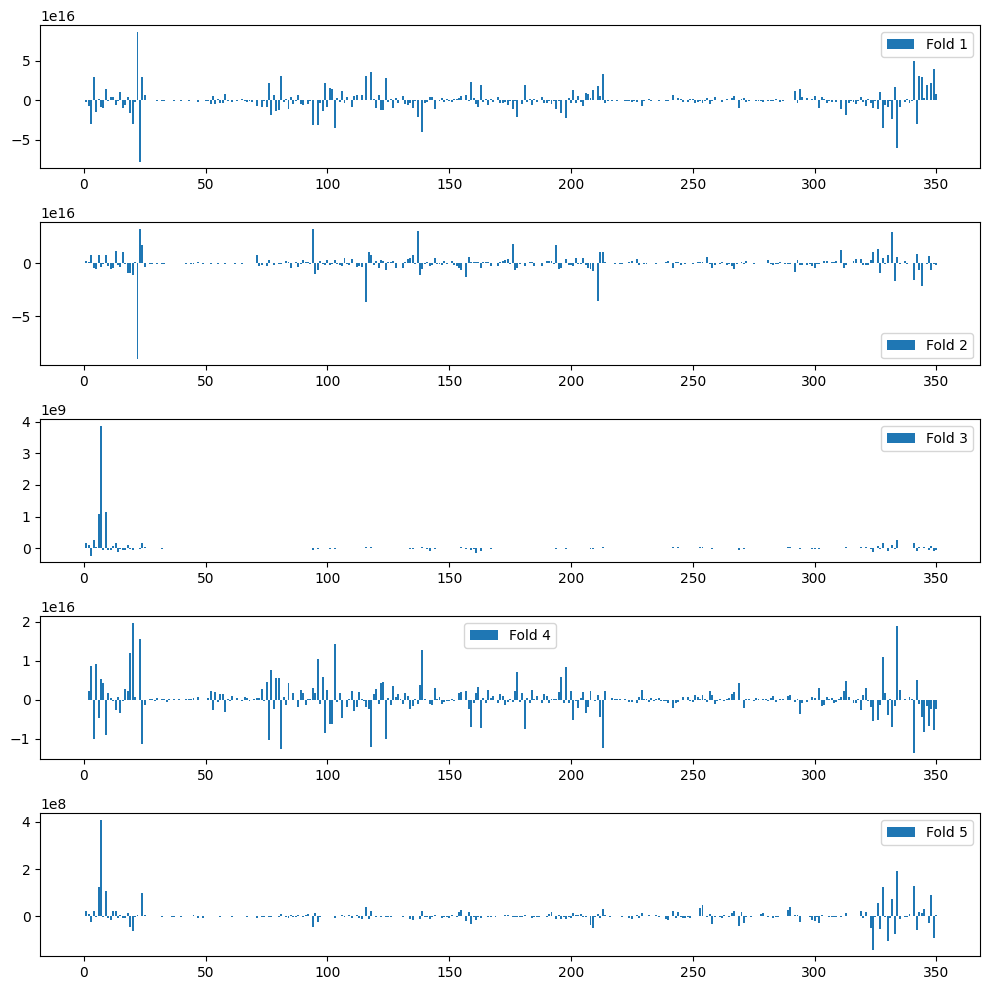

In [151]:
mae = []
subplot_coefficients = []

for train_index, test_index in indexes:
    x_train_pca_i = x_train_pca.iloc[train_index,:]
    x_test_pca_i = x_train_pca.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    poly = PolynomialFeatures(interaction_only=False, include_bias=True, degree=2)
    poly.fit(x_train_pca_i)
    x_inter_train_i = poly.transform(x_train_pca_i)
    x_inter_test_i = poly.transform(x_test_pca_i)

    regressor = LinearRegression(fit_intercept=True) # izbor boljeg hiperparametra
    regressor.fit(x_inter_train_i, y_train_i)
    y_pred = regressor.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)

    print('MAE: ', mae_i)
    subplot_coefficients.append(regressor.coef_)

    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))
print("Max coefficient: ", np.max(subplot_coefficients[0]))
plot_coefficients(subplot_coefficients, 5)

In [152]:
 # promena hiperparametra

mae = []
for train_index, test_index in indexes:
    x_train_pca_i = x_train_pca.iloc[train_index,:]
    x_test_pca_i = x_train_pca.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    poly = PolynomialFeatures(interaction_only=False, include_bias=True, degree=2)
    poly.fit(x_train_pca_i)
    x_inter_train_i = poly.transform(x_train_pca_i)
    x_inter_test_i = poly.transform(x_test_pca_i)

    regressor = LinearRegression(fit_intercept=False) # izbor boljeg hiperparametra
    regressor.fit(x_inter_train_i, y_train_i)
    y_pred = regressor.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  5151496.76546417
MAE:  5126540.110624484
MAE:  5161143.017702747
MAE:  5236242.862829535
MAE:  5210044.1742285015

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  5177093.386169887


In [153]:
# V model, hipoteza 3.stepena sa interakcijama
# 1. slucaj, bez PCA

# y=b0+b1x1+b2x2+b3x3+...+bdxd+c1x1x2+c2x1x3+c3x2x3+...+d1x21+d2x22+d3x23+...+dnx2n+e1x31+e2x32+e3x33+...+dnx3n

In [154]:
mae = []
for train_index, test_index in indexes:
    x_train_i = x_train.iloc[train_index,:]
    x_test_i = x_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)

    poly = PolynomialFeatures(interaction_only=False, include_bias=True, degree=3)
    poly.fit(x_train_std_i)
    x_inter_train_i = poly.transform(x_train_std_i)
    x_inter_test_i = poly.transform(x_test_std_i)

    regressor = LinearRegression(fit_intercept=True) # izbor boljeg hiperparametra
    regressor.fit(x_inter_train_i, y_train_i)
    y_pred = regressor.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  104363525243066.77
MAE:  135657338842362.45
MAE:  658143119516218.5
MAE:  181294567676008.0
MAE:  55585875103630.945

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  227008885276257.34


In [155]:
mae = []
subplot_coefficients = []

for train_index, test_index in indexes:
    x_train_i = x_train.iloc[train_index,:]
    x_test_i = x_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)

    poly = PolynomialFeatures(interaction_only=False, include_bias=True, degree=3)
    poly.fit(x_train_std_i)
    x_inter_train_i = poly.transform(x_train_std_i)
    x_inter_test_i = poly.transform(x_test_std_i)

    regressor = LinearRegression(fit_intercept=False) # izbor boljeg hiperparametra
    regressor.fit(x_inter_train_i, y_train_i)
    y_pred = regressor.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    
    print('MAE: ', mae_i)
    subplot_coefficients.append(regressor.coef_)

    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  10031907.405323487
MAE:  7889066.1010040855
MAE:  6522807.9182451675
MAE:  67487106.61737567
MAE:  7633137.3379156105

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  19912805.075972803


In [156]:
# V model, hipoteza 3.stepena sa interakcijama
# 2. slucaj, sa PCA

# y=b0+b1x1+b2x2+b3x3+...+bdxd+c1x1x2+c2x1x3+c3x2x3+...+d1x21+d2x22+d3x23+...+dnx2n+e1x31+e2x32+e3x33+...+dnx3n

In [157]:
mae = []
for train_index, test_index in indexes:
    x_train_pca_i = x_train_pca.iloc[train_index,:]
    x_test_pca_i = x_train_pca.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    poly = PolynomialFeatures(interaction_only=False, include_bias=True, degree=3)
    poly.fit(x_train_pca_i)
    x_inter_train_i = poly.transform(x_train_pca_i)
    x_inter_test_i = poly.transform(x_test_pca_i)

    regressor = LinearRegression(fit_intercept=True) # izbor boljeg hiperparametra
    regressor.fit(x_inter_train_i, y_train_i)
    y_pred = regressor.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  86791558524972.52
MAE:  4523947683773.328
MAE:  289141192964263.2
MAE:  94415646043236.64
MAE:  85064364777102.52

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  111987341998669.62


In [158]:
# promena hiperparametra

mae = []
for train_index, test_index in indexes:
    x_train_pca_i = x_train_pca.iloc[train_index,:]
    x_test_pca_i = x_train_pca.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    poly = PolynomialFeatures(interaction_only=False, include_bias=True, degree=3)
    poly.fit(x_train_pca_i)
    x_inter_train_i = poly.transform(x_train_pca_i)
    x_inter_test_i = poly.transform(x_test_pca_i)

    regressor = LinearRegression(fit_intercept=False) # izbor boljeg hiperparametra
    regressor.fit(x_inter_train_i, y_train_i)
    y_pred = regressor.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  396778525849.88464
MAE:  294144443184.95264
MAE:  13240100061266.57
MAE:  2793557139825.4434
MAE:  14711897264898.713

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  6287295487005.112


In [159]:
# VI model, model sa ridge regularizacijom i osnovnom hipotezom. 
# 1. slucaj, bez PCA

# Ridge regularizacija podrazumeva uvođenje regularizacije u funkciju cene
# J = 1/N *∑(yi−yi^)^2 + α∑jθj^2

MAE:  6324255.426814689
MAE:  6208971.880291496
MAE:  6178109.394814515
MAE:  6270323.859236434
MAE:  6307072.226070291

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  6257746.557445485
Max coefficient:  7250271.53980646


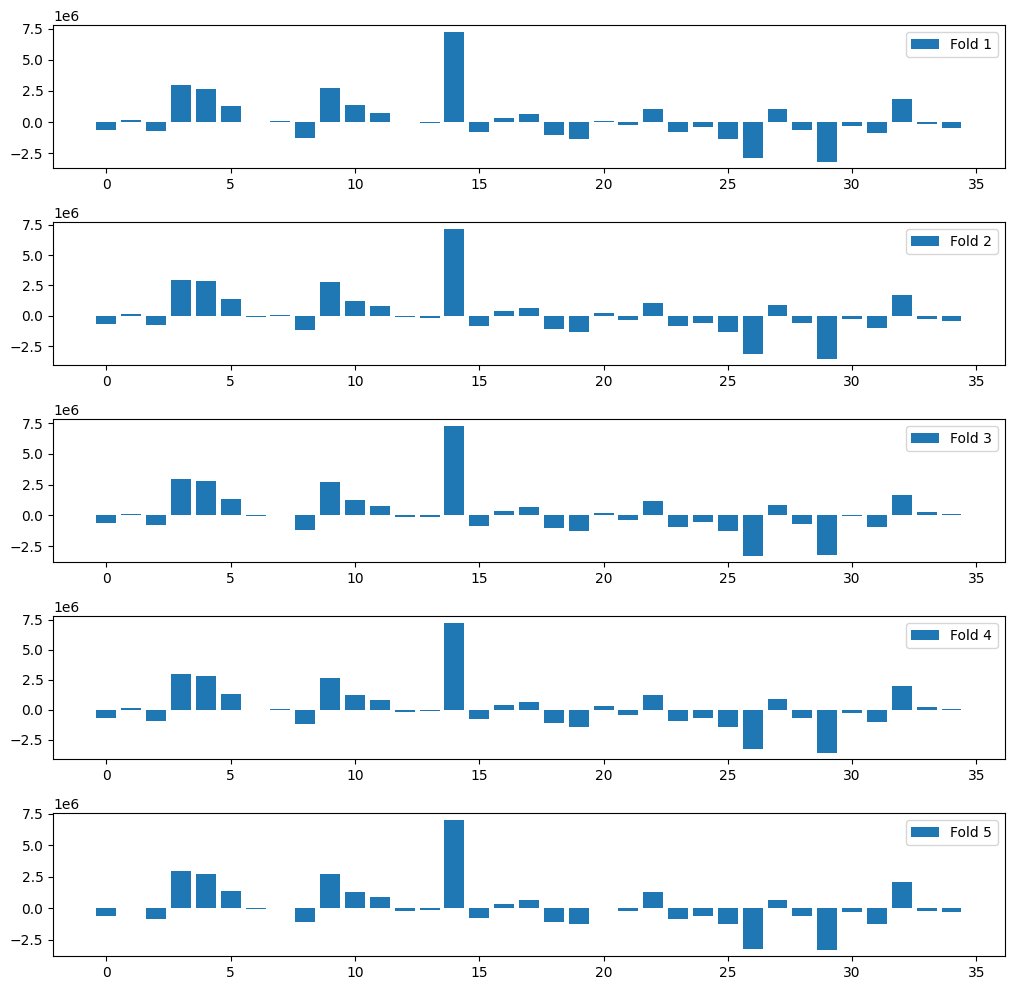

In [160]:
mae = []
subplot_coefficients = []

for train_index, test_index in indexes:
    x_train_i = x_train.iloc[train_index,:]
    x_test_i = x_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)

    ridge_model = Ridge(alpha=5) # izbor boljeg hiperparametra? probao i nista bolje
    ridge_model.fit(x_train_std_i, y_train_i)
    y_pred = ridge_model.predict(x_test_std_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)

    print('MAE: ', mae_i)
    subplot_coefficients.append(ridge_model.coef_)

    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))
print("Max coefficient: ", np.max(subplot_coefficients[0]))
plot_coefficients(subplot_coefficients, 5)


In [161]:
# VI model, model sa ridge regularizacijom i osnovnom hipotezom. 
# 2. slucaj, sa PCA

# Ridge regularizacija podrazumeva uvođenje regularizacije u funkciju cene
# J = 1/N *∑(yi−yi^)^2 + α∑jθj^2

In [162]:
mae = []
for train_index, test_index in indexes:
    x_train_pca_i = x_train_pca.iloc[train_index,:]
    x_test_pca_i = x_train_pca.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    ridge_model = Ridge(alpha=5) # izbor boljeg hiperparametra? probao razlicite vrednosti, isti rezultat
    ridge_model.fit(x_train_pca_i, y_train_i)
    y_pred = ridge_model.predict(x_test_pca_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  6309901.688927767
MAE:  6196132.516364577
MAE:  6171484.35305778
MAE:  6252981.630829292
MAE:  6300674.603071145

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  6246234.9584501125


In [163]:
# VII model, model sa lasso regularizacijom i osnovnom hipotezom.
# 1. slucaj, bez PCA

# Lasso regularizacija podrazumeva uvođenje regularizacije u funkciju cene
# J = 1/N *∑(yi−yi^)^2+ α∑j|θj|

c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.868e+17, tolerance: 6.871e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  6324911.91636813


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.107e+17, tolerance: 7.020e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  6209735.810965342


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.986e+17, tolerance: 7.009e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  6178807.789426381


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.940e+17, tolerance: 6.978e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  6271557.301353701


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.945e+17, tolerance: 6.886e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  6307716.103505766


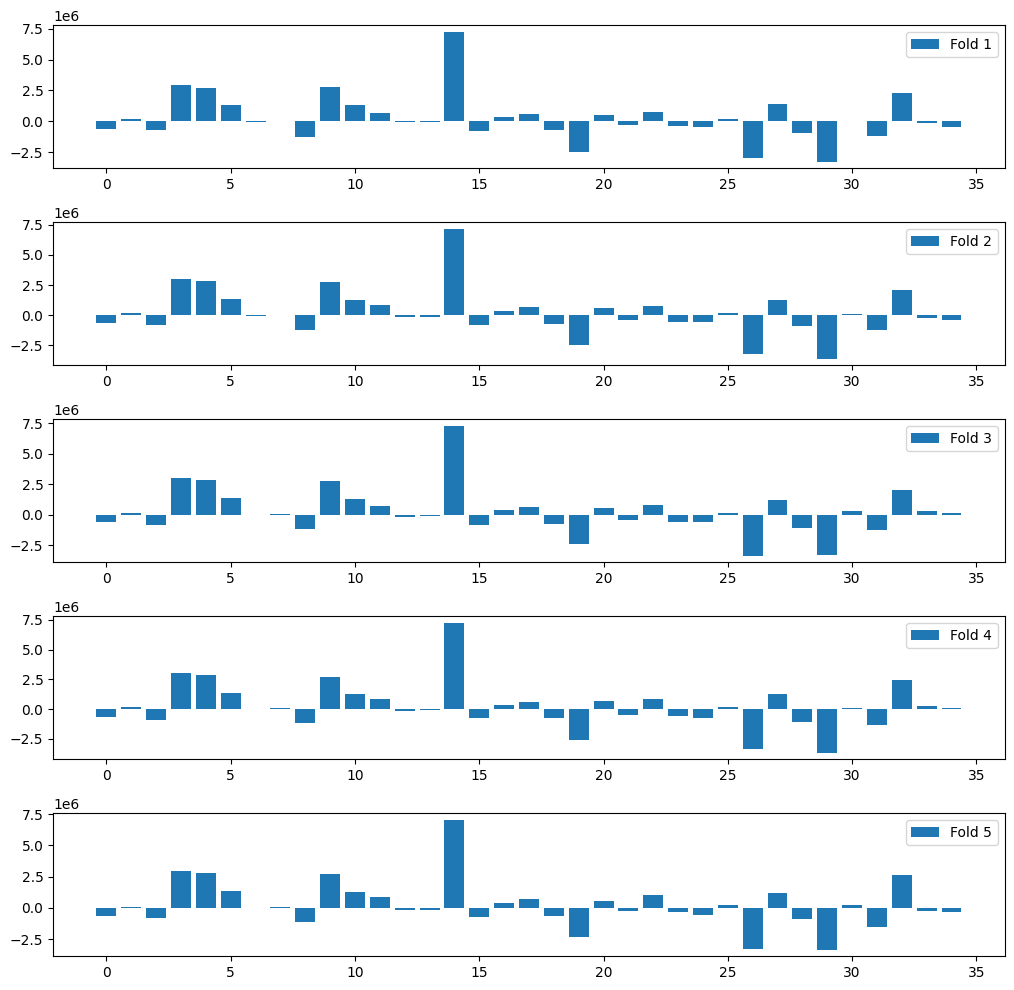


Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  6258545.784323864


In [164]:
mae = []
subplot_coefficients = []

for train_index, test_index in indexes:
    x_train_i = x_train.iloc[train_index,:]
    x_test_i = x_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)

    lasso_model = Lasso(alpha=0.01) # izbor boljeg hiperparametra? probao 0.05, 0.5, 1, 5 isti rezultat
    lasso_model.fit(x_train_std_i, y_train_i)
    y_pred = lasso_model.predict(x_test_std_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)

    print('MAE: ', mae_i)
    subplot_coefficients.append(lasso_model.coef_)

    mae.append(mae_i)

plot_coefficients(subplot_coefficients, 5)
print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

In [165]:
# VII model, model sa lasso regularizacijom i osnovnom hipotezom.
# 2. slucaj, sa PCA

# Lasso regularizacija podrazumeva uvođenje regularizacije u funkciju cene
# J = 1/N *∑(yi−yi^)^2+ α∑j|θj|

In [166]:
mae = []
for train_index, test_index in indexes:
    x_train_pca_i = x_train_pca.iloc[train_index,:]
    x_test_pca_i = x_train_pca.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    lasso_model = Lasso(alpha=0.01) # izbor boljeg hiperparametra?
    lasso_model.fit(x_train_pca_i, y_train_i)
    y_pred = lasso_model.predict(x_test_pca_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  6310238.292152903
MAE:  6196440.404601075
MAE:  6171845.381028023
MAE:  6253346.566598257
MAE:  6300949.429681544

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  6246564.01481236


In [167]:
# VIII model
# Model sa ridge regularizacijom i hipotezom drugog stepena.
# 1. slucaj, bez PCA

MAE:  5101462.333003231
MAE:  5071876.657373201
MAE:  5114414.296978101
MAE:  5157997.940103749
MAE:  5190607.547923688

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  5127271.755076394
Max coefficient:  8301832.319050723


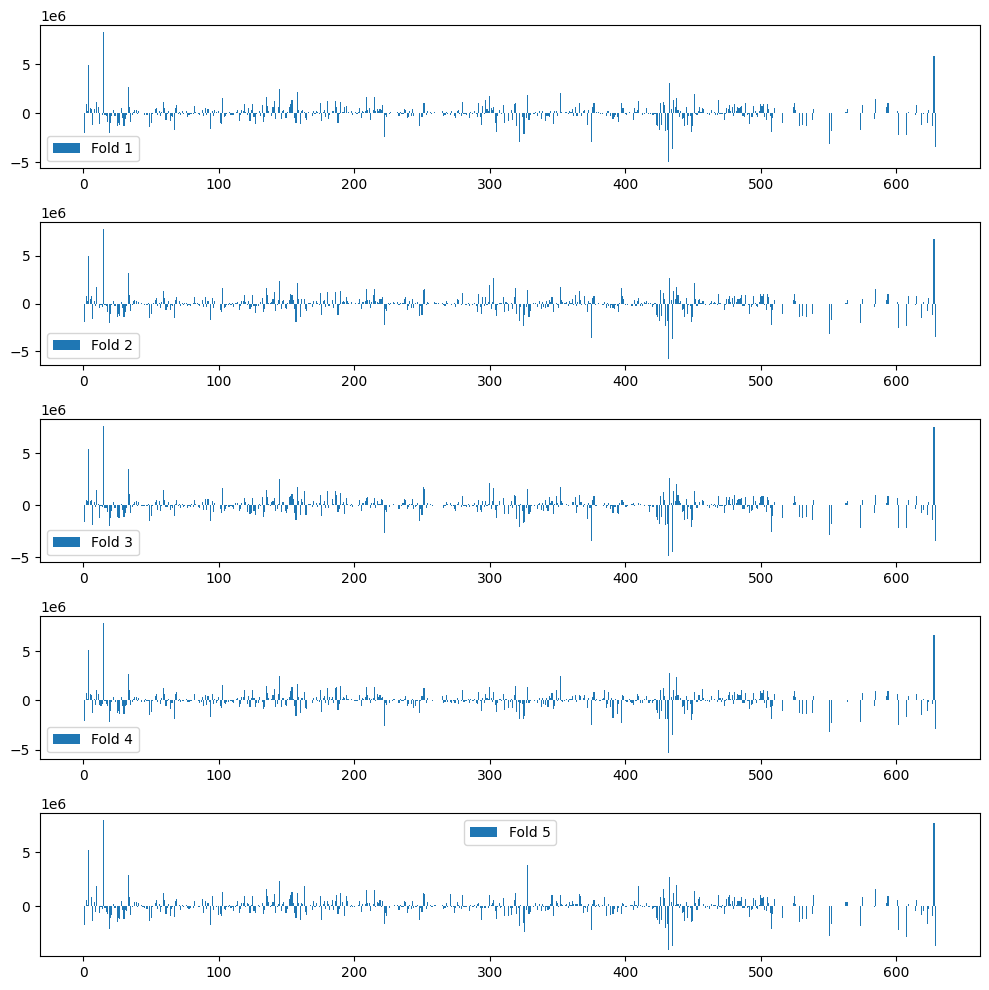

In [168]:
mae = []
subplot_coefficients = []

for train_index, test_index in indexes:
    x_train_i = x_train.iloc[train_index,:]
    x_test_i = x_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)

    poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=2)
    poly.fit(x_train_std_i)
    x_inter_train_i = poly.transform(x_train_std_i)
    x_inter_test_i = poly.transform(x_test_std_i)

    ridge_model2 = Ridge(alpha=20) # izbor boljeg hiperparametra?
    ridge_model2.fit(x_inter_train_i, y_train_i)
    y_pred = ridge_model2.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    
    print('MAE: ', mae_i)
    subplot_coefficients.append(ridge_model2.coef_)

    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))
print("Max coefficient: ", np.max(subplot_coefficients[0]))
plot_coefficients(subplot_coefficients, 5)

In [169]:
# VIII model
# Model sa ridge regularizacijom i hipotezom drugog stepena.
# 2. slucaj, sa PCA

In [170]:
mae = []
for train_index, test_index in indexes:
    x_train_pca_i = x_train_pca.iloc[train_index,:]
    x_test_pca_i = x_train_pca.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=2)
    poly.fit(x_train_pca_i)
    x_inter_train_i = poly.transform(x_train_pca_i)
    x_inter_test_i = poly.transform(x_test_pca_i)

    ridge_model2 = Ridge(alpha=5) # izbor boljeg hiperparametra?
    ridge_model2.fit(x_inter_train_i, y_train_i)
    y_pred = ridge_model2.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  5226242.567248443
MAE:  5187270.52046054
MAE:  5226731.857964063
MAE:  5300947.882592371
MAE:  5267926.460386973

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  5241823.857730478


In [171]:
# IX model
# Model sa ridge regularizacijom i hipotezom treceg stepena
# 1. slucaj, bez PCA

In [172]:
mae = []
for train_index, test_index in indexes:
    x_train_i = x_train.iloc[train_index,:]
    x_test_i = x_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)

    poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=3)
    poly.fit(x_train_std_i)
    x_inter_train_i = poly.transform(x_train_std_i)
    x_inter_test_i = poly.transform(x_test_std_i)

    ridge_model2 = Ridge(alpha=20) # izbor boljeg hiperparametra?
    ridge_model2.fit(x_inter_train_i, y_train_i)
    y_pred = ridge_model2.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  5200807.947805445
MAE:  5201623.739799997
MAE:  5171952.137158587
MAE:  5323978.565671441
MAE:  5377620.743807094

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  5255196.626848513


In [173]:
# IX model
# Model sa ridge regularizacijom i hipotezom treceg stepena.
# 2. slucaj, sa PCA

In [174]:
mae = []
for train_index, test_index in indexes:
    x_train_pca_i = x_train_pca.iloc[train_index,:]
    x_test_pca_i = x_train_pca.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=3)
    poly.fit(x_train_pca_i)
    x_inter_train_i = poly.transform(x_train_pca_i)
    x_inter_test_i = poly.transform(x_test_pca_i)

    ridge_model2 = Ridge(alpha=5) # izbor boljeg hiperparametra?
    ridge_model2.fit(x_inter_train_i, y_train_i)
    y_pred = ridge_model2.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

MAE:  5788080.793964618
MAE:  5944557.242868404
MAE:  7056790.853250749
MAE:  6377146.805970629
MAE:  6031801.825068601

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  6239675.5042246


In [175]:
# X model
# Model sa lasso regularizacijom i hipotezom drugog stepena.
# 1. slucaj, bez PCA

In [176]:
mae = []
for train_index, test_index in indexes:
    x_train_i = x_train.iloc[train_index,:]
    x_test_i = x_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)

    poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=2)
    poly.fit(x_train_std_i)
    x_inter_train_i = poly.transform(x_train_std_i)
    x_inter_test_i = poly.transform(x_test_std_i)

    lasso_model2 = Lasso(alpha=0.01) # izbor boljeg hiperparametra?
    lasso_model2.fit(x_inter_train_i, y_train_i)
    y_pred = lasso_model2.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.072e+18, tolerance: 6.871e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5116020.667396755


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.087e+18, tolerance: 7.020e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5088600.416608216


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.070e+18, tolerance: 7.009e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5414849.9931684295


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.056e+18, tolerance: 6.978e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5192450.478755386
MAE:  5198746.699569532

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  5202133.651099663


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.067e+18, tolerance: 6.886e+14
  model = cd_fast.enet_coordinate_descent(


In [177]:
# X model
# Model sa lasso regularizacijom i hipotezom drugog stepena.
# 2. slucaj, sa PCA

In [178]:
mae = []
for train_index, test_index in indexes:
    x_train_pca_i = x_train_pca.iloc[train_index,:]
    x_test_pca_i = x_train_pca.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=2)
    poly.fit(x_train_pca_i)
    x_inter_train_i = poly.transform(x_train_pca_i)
    x_inter_test_i = poly.transform(x_test_pca_i)

    lasso_model2 = Lasso(alpha=0.01) # izbor boljeg hiperparametra?
    lasso_model2.fit(x_inter_train_i, y_train_i)
    y_pred = lasso_model2.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.109e+18, tolerance: 6.871e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5217893.795226572


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.123e+18, tolerance: 7.020e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5188147.628523029


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.106e+18, tolerance: 7.009e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5230659.137911402


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+18, tolerance: 6.978e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5304420.007293881
MAE:  5263970.064389363

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  5241018.12666885


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.103e+18, tolerance: 6.886e+14
  model = cd_fast.enet_coordinate_descent(


In [179]:
# XI model
# Model sa lasso regularizacijom i hipotezom treceg stepena.
# 1. slucaj, bez PCA

In [180]:
mae = []
for train_index, test_index in indexes:
    x_train_i = x_train.iloc[train_index,:]
    x_test_i = x_train.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    x_train_std_i, x_test_std_i = standardizacija(x_train_i, x_test_i)

    poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=3)
    poly.fit(x_train_std_i)
    x_inter_train_i = poly.transform(x_train_std_i)
    x_inter_test_i = poly.transform(x_test_std_i)

    lasso_model2 = Lasso(alpha=0.01) # izbor boljeg hiperparametra?
    lasso_model2.fit(x_inter_train_i, y_train_i)
    y_pred = lasso_model2.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.519e+17, tolerance: 6.871e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5705965.413039164


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.580e+17, tolerance: 7.020e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5653406.4697528705


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.495e+17, tolerance: 7.009e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  8826630.192386057


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.411e+17, tolerance: 6.978e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5927981.655361546
MAE:  5844870.233086474

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  6391770.792725222


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.431e+17, tolerance: 6.886e+14
  model = cd_fast.enet_coordinate_descent(


In [181]:
# XI model
# Model sa lasso regularizacijom i hipotezom treceg stepena.
# 2. slucaj, sa PCA

In [182]:
mae = []
for train_index, test_index in indexes:
    x_train_pca_i = x_train_pca.iloc[train_index,:]
    x_test_pca_i = x_train_pca.iloc[test_index,:]
    y_train_i = y_train.iloc[train_index]
    y_test_i = y_train.iloc[test_index]

    poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=3)
    poly.fit(x_train_pca_i)
    x_inter_train_i = poly.transform(x_train_pca_i)
    x_inter_test_i = poly.transform(x_test_pca_i)

    lasso_model2 = Lasso(alpha=0.01) # izbor boljeg hiperparametra?
    lasso_model2.fit(x_inter_train_i, y_train_i)
    y_pred = lasso_model2.predict(x_inter_test_i)
    mae_i = mean_absolute_error(y_test_i, y_pred)
    print('MAE: ', mae_i)
    mae.append(mae_i)

print("\nProsecna mera srednje apsolutne greske iz unakrsne validacije je: ")
print("MAE: ", np.mean(mae))

c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.995e+17, tolerance: 6.871e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5435494.398912994


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.066e+17, tolerance: 7.020e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5439961.315384049


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.949e+17, tolerance: 7.009e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5585447.06713609


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.827e+17, tolerance: 6.978e+14
  model = cd_fast.enet_coordinate_descent(


MAE:  5738686.350874057
MAE:  5764982.288328797

Prosecna mera srednje apsolutne greske iz unakrsne validacije je: 
MAE:  5592914.284127197


c:\Users\Vasilije\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.855e+17, tolerance: 6.886e+14
  model = cd_fast.enet_coordinate_descent(


In [407]:
# KNN regresor
# bez standardizacije
# 1. slucaj, bez PCA

In [412]:
parameters = {
    'n_neighbors': [1, 2, 3, 4, 5],
    'metric': ['hamming', 'euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'weights': ['uniform', 'distance'],
    'p': [5]  # samo utice na Minkowski metriku
}

regressor = KNeighborsRegressor()
clf = GridSearchCV(regressor, parameters, scoring='neg_mean_absolute_error', cv=kf, verbose=3)
clf.fit(x_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END metric=hamming, n_neighbors=1, p=5, weights=uniform;, score=-6570583.787 total time=   6.2s
[CV 2/5] END metric=hamming, n_neighbors=1, p=5, weights=uniform;, score=-6565295.210 total time=   6.0s
[CV 3/5] END metric=hamming, n_neighbors=1, p=5, weights=uniform;, score=-6510352.262 total time=   5.7s
[CV 4/5] END metric=hamming, n_neighbors=1, p=5, weights=uniform;, score=-6628862.943 total time=   5.7s
[CV 5/5] END metric=hamming, n_neighbors=1, p=5, weights=uniform;, score=-6889694.839 total time=   5.9s
[CV 1/5] END metric=hamming, n_neighbors=1, p=5, weights=distance;, score=-6570583.787 total time=   6.1s
[CV 2/5] END metric=hamming, n_neighbors=1, p=5, weights=distance;, score=-6565295.210 total time=   6.0s
[CV 3/5] END metric=hamming, n_neighbors=1, p=5, weights=distance;, score=-6510352.262 total time=   5.7s
[CV 4/5] END metric=hamming, n_neighbors=1, p=5, weights=distance;, score=-6628862.943 total ti

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsRegressor(),
             param_grid={'metric': ['hamming', 'euclidean', 'manhattan',
                                    'minkowski', 'chebyshev'],
                         'n_neighbors': [1, 2, 3, 4, 5], 'p': [5],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=3)

In [414]:
print("najbolji skor: ", clf.best_score_)
print("najbolji hiperparametri: ", clf.best_params_)

najbolji skor:  -4924089.068735683
najbolji hiperparametri:  {'metric': 'manhattan', 'n_neighbors': 4, 'p': 5, 'weights': 'distance'}


In [ ]:
# KNN regresor
# bez standardizacije
# 2. slucaj, sa PCA

In [416]:
parameters = {
    'n_neighbors': [1, 2, 3, 4, 5],
    'metric': ['hamming', 'euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'weights': ['uniform', 'distance']  
}
regressor = KNeighborsRegressor()
clf = GridSearchCV(regressor, parameters, scoring='neg_mean_absolute_error', cv=kf, verbose=3)
clf.fit(x_train_pca, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END metric=hamming, n_neighbors=1, weights=uniform;, score=-8634445.403 total time=   4.4s
[CV 2/5] END metric=hamming, n_neighbors=1, weights=uniform;, score=-9302341.781 total time=   4.5s
[CV 3/5] END metric=hamming, n_neighbors=1, weights=uniform;, score=-9188218.124 total time=   4.6s
[CV 4/5] END metric=hamming, n_neighbors=1, weights=uniform;, score=-9209897.837 total time=   4.4s
[CV 5/5] END metric=hamming, n_neighbors=1, weights=uniform;, score=-9507883.110 total time=   4.1s
[CV 1/5] END metric=hamming, n_neighbors=1, weights=distance;, score=-8634445.403 total time=   4.2s
[CV 2/5] END metric=hamming, n_neighbors=1, weights=distance;, score=-9302341.781 total time=   4.5s
[CV 3/5] END metric=hamming, n_neighbors=1, weights=distance;, score=-9188218.124 total time=   4.7s
[CV 4/5] END metric=hamming, n_neighbors=1, weights=distance;, score=-9209897.837 total time=   4.6s
[CV 5/5] END metric=hamming, n_nei

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsRegressor(),
             param_grid={'metric': ['hamming', 'euclidean', 'manhattan',
                                    'minkowski', 'chebyshev'],
                         'n_neighbors': [1, 2, 3, 4, 5],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=3)

In [417]:
print("najbolji skor: ", clf.best_score_)
print("najbolji hiperparametri: ", clf.best_params_)

najbolji skor:  -5030047.482091634
najbolji hiperparametri:  {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
# KNN regresor
# sa standardizacijom

In [419]:
x_train_std, x_test_std = standardizacija(x_train, x_test)

In [420]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_neighbors': [1, 2, 3, 4, 5],
    'metric': ['hamming', 'euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'weights': ['uniform', 'distance']  
}
regressor = KNeighborsRegressor()
clf = GridSearchCV(regressor, parameters, scoring='neg_mean_absolute_error', cv=kf, verbose=3)
clf.fit(x_train_std, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END metric=hamming, n_neighbors=1, weights=uniform;, score=-6570583.787 total time=   6.3s
[CV 2/5] END metric=hamming, n_neighbors=1, weights=uniform;, score=-6565295.210 total time=   6.1s
[CV 3/5] END metric=hamming, n_neighbors=1, weights=uniform;, score=-6510352.262 total time=   6.0s
[CV 4/5] END metric=hamming, n_neighbors=1, weights=uniform;, score=-6628862.943 total time=   6.1s
[CV 5/5] END metric=hamming, n_neighbors=1, weights=uniform;, score=-6889694.839 total time=   6.1s
[CV 1/5] END metric=hamming, n_neighbors=1, weights=distance;, score=-6570583.787 total time=   6.0s
[CV 2/5] END metric=hamming, n_neighbors=1, weights=distance;, score=-6565295.210 total time=   6.4s
[CV 3/5] END metric=hamming, n_neighbors=1, weights=distance;, score=-6510352.262 total time=   6.2s
[CV 4/5] END metric=hamming, n_neighbors=1, weights=distance;, score=-6628862.943 total time=   6.0s
[CV 5/5] END metric=hamming, n_nei

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsRegressor(),
             param_grid={'metric': ['hamming', 'euclidean', 'manhattan',
                                    'minkowski', 'chebyshev'],
                         'n_neighbors': [1, 2, 3, 4, 5],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=3)

In [421]:
print("najbolji skor: ", clf.best_score_)
print("najbolji hiperparametri: ", clf.best_params_)

najbolji skor:  -4653685.6554432865
najbolji hiperparametri:  {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [39]:
# SVR, support vector regression
# pripremni proracuni

# Prvo, provera brzine izvrsavanja obuke modela => 62 sek

regressor = SVR(kernel = 'rbf')
regressor.fit(x_train_std, y_train)

SVR()

In [40]:
# provera brzine izvrsavanja evaluacije nad citavim skupom uzoraka => 15,2 sek

y_predict = regressor.predict(x_test_std)
mae = mean_absolute_error(y_test, y_predict)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 8186875.106882387


In [41]:
# provera brzine izvrsavanja obuke modela => 14 sek
# => zakljucak, odabir optimalnih hiperparametara nad manjim podskupom (20000 uzoraka)

x_sampled = x.sample(n=20000, random_state=42)
y_sampled = y.loc[x_sampled.index]

x_train_sampled, x_test_sampled, y_train_sampled, y_test_sampled = train_test_split(x_sampled, y_sampled, test_size=0.1,random_state=42)

x_train_std_sampled, x_test_std_sampled = standardizacija(x_train_sampled, x_test_sampled)

regressor = SVR(kernel = 'rbf')
regressor.fit(x_train_std_sampled, y_train_sampled)

SVR()

In [42]:
# provera brzine izvrsavanja evaluacije i nad 20k uzoraka => 3,5 sek

y_predict = regressor.predict(x_test_std_sampled)
mae = mean_absolute_error(y_test_sampled, y_predict)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 8673754.181876665


In [43]:
# SVR
# 1. slucaj, bez PCA

# provera brzine izvrsavanja obuke modela => 7,7 sek
# => zakljucak, odabir optimalnih hiperparametara nad manjim podskupom (15000 uzoraka)

x_sampled = x.sample(n=15000, random_state=42)
y_sampled = y.loc[x_sampled.index]

x_train_sampled, x_test_sampled, y_train_sampled, y_test_sampled = train_test_split(x_sampled, y_sampled, test_size=0.1,random_state=42)

x_train_std_sampled, x_test_std_sampled = standardizacija(x_train_sampled, x_test_sampled)

regressor = SVR(kernel = 'rbf')
regressor.fit(x_train_std_sampled, y_train_sampled)

SVR()

In [44]:
# provera brzine izvrsavanja evaluacije i nad 15k uzoraka => 1,9 sek

y_predict = regressor.predict(x_test_std_sampled)
mae = mean_absolute_error(y_test_sampled, y_predict)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 8750724.83655729


In [45]:
param = {
    'kernel': ('linear', 'poly', 'rbf'), 
    'C': [0.5, 1, 10, 0.01], 
    'degree': [3, 8], 
    'coef0': [0.01, 2], 
    'gamma': ('auto', 'scale', 0.15, 0.001)
}

modelsvr = SVR()

grid_search = GridSearchCV(estimator=modelsvr, scoring='neg_mean_absolute_error', param_grid=param, cv=5, n_jobs=6, verbose=3)

grid_search.fit(x_train_std_sampled, y_train_sampled)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=6,
             param_grid={'C': [0.5, 1, 10, 0.01], 'coef0': [0.01, 2],
                         'degree': [3, 8],
                         'gamma': ('auto', 'scale', 0.15, 0.001),
                         'kernel': ('linear', 'poly', 'rbf')},
             scoring='neg_mean_absolute_error', verbose=3)

In [46]:
print(grid_search.best_params_)

{'C': 10, 'coef0': 2, 'degree': 8, 'gamma': 'scale', 'kernel': 'poly'}


In [47]:
print("Mean Absolute Error: \n")
print(grid_search.best_score_)

Mean Absolute Error: 

-6126518.348631327


In [ ]:
# SVR
# 2. slucaj, sa PCA

In [48]:
# test, u kojem dobijamo da je za jednu obuku potrebno 62 s 

regressor = SVR(kernel = 'rbf')
regressor.fit(x_train_pca, y_train)

SVR()

In [49]:
x_test_pca.shape

(4188, 25)

In [50]:
x_train_pca.shape

(37685, 25)

In [51]:
y_train

18080     9000000
32164     2000000
23717    22000000
20046    10000000
14922     1000000
           ...   
6265      3200000
11284    25000000
38158     2300000
860      28000000
15795     8000000
Name: market_value_on_valuation_date, Length: 37685, dtype: int64

In [52]:
x_train_pca

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24
18080,0.825286,0.259374,-2.553987,-1.050307,1.180450,-0.830193,0.351559,0.209768,-1.161730,0.308639,...,0.746664,0.838496,2.193286,-0.198801,0.041685,0.101066,-1.133756,0.441877,-0.227627,0.233276
32164,-1.476395,0.142383,-0.424406,-1.334522,0.400558,-0.258164,0.290643,0.310805,-0.489949,0.490208,...,-0.020075,-0.120363,-0.473688,-0.550266,-0.710579,-0.044489,0.165826,0.090941,-0.472941,0.059414
23717,1.305978,-1.713143,1.139854,0.685665,-1.874970,2.047912,-0.672061,-0.885148,0.420723,1.661864,...,-0.816788,0.697350,0.786580,-0.107873,0.666621,0.262516,0.069512,0.160368,-0.059711,-0.630448
20046,0.539794,-0.901357,1.630351,-0.879409,-0.095951,-1.055252,0.314014,-0.297219,0.359228,0.515036,...,0.974858,-0.624520,-0.270113,-0.362672,0.099560,0.334704,-0.281427,0.183327,-0.103655,-0.205089
14922,-0.474266,-0.206793,-0.452531,-0.737500,-0.410227,-0.233034,0.171224,-0.050860,-0.457319,0.585987,...,-0.457415,0.587756,1.220808,-0.901454,0.120640,0.650008,-0.137222,0.148285,0.161340,0.210410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,-1.727048,0.411730,-0.140480,-0.632653,0.275595,-0.796337,0.285145,0.110341,-0.069416,0.451382,...,-0.229833,1.169001,-0.220690,0.075084,0.242603,-0.002298,-0.805144,0.370733,-0.193217,0.061317
11284,-0.095074,-0.261357,0.909025,0.032391,0.457457,-1.100220,0.205424,-0.294910,0.167546,0.040532,...,-0.674243,0.674969,0.732042,-0.148752,-0.750027,-0.066763,0.049829,0.253831,0.240371,0.267794
38158,-1.770455,0.337098,-0.379122,-0.520474,0.845017,-1.264617,0.448980,0.163201,-0.311743,0.543383,...,-0.222498,-0.032382,-0.444705,0.310943,0.599776,-0.013425,0.712017,-0.081761,0.005319,-0.158132
860,7.260295,1.733655,4.875929,-1.827270,0.620768,0.041365,-1.033680,-0.899728,3.356438,-2.055355,...,-0.935821,0.219081,0.134537,-1.833411,-0.072200,-0.197532,0.632639,-0.260495,-0.388996,-0.102072


In [53]:
# za 15000 uzorak je potrebno => 8,1 s

x_train_pca_sampled = x_train_pca.sample(n=13500, random_state=42)
y_train_pca_sampled = y_train.loc[x_train_pca_sampled.index]

x_test_pca_sampled = x_test_pca.sample(n=1500, random_state=42)
y_test_pca_sampled = y_test.loc[x_test_pca_sampled.index]

regressor = SVR(kernel = 'rbf')
regressor.fit(x_train_pca_sampled, y_train_pca_sampled)

SVR()

In [54]:
# provera brzine izvrsavanja evaluacije i za 15000 uzorak => 2 sek

y_predict = regressor.predict(x_test_pca_sampled)
mae = mean_absolute_error(y_test_pca_sampled, y_predict)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 8324966.347082012


In [55]:
param = {
    'kernel': ('linear', 'poly', 'rbf'), 
    'C': [0.5, 1, 10, 0.01], 
    'degree': [3, 8], 
    'coef0': [0.01, 2], 
    'gamma': ('auto', 'scale', 0.15, 0.001)
}

modelsvr = SVR()

grid_search = GridSearchCV(estimator=modelsvr, scoring='neg_mean_absolute_error', param_grid=param, cv=5, n_jobs=6, verbose=3)

grid_search.fit(x_train_pca_sampled, y_train_pca_sampled)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=6,
             param_grid={'C': [0.5, 1, 10, 0.01], 'coef0': [0.01, 2],
                         'degree': [3, 8],
                         'gamma': ('auto', 'scale', 0.15, 0.001),
                         'kernel': ('linear', 'poly', 'rbf')},
             scoring='neg_mean_absolute_error', verbose=3)

In [58]:
print(grid_search.best_params_)

{'C': 10, 'coef0': 2, 'degree': 8, 'gamma': 'auto', 'kernel': 'poly'}


In [59]:
print("Mean Absolute Error:")
print(grid_search.best_score_)

Mean Absolute Error:
-6135983.873590739


In [ ]:
# Sledi obucavanje modela svakog od 3 algoritma sa optimalnim hiperparametrima

In [ ]:
# VIII model
# Model sa ridge regularizacijom i hipotezom drugog stepena.
# 1. slucaj, bez PCA

In [215]:
poly = PolynomialFeatures(interaction_only=True, include_bias=True, degree=2)
poly.fit(x_train)
x_inter_train = poly.transform(x_train)
x_inter_test = poly.transform(x_test)

ridge_model = Ridge(alpha=20) 
ridge_model.fit(x_inter_train, y_train)
y_pred = ridge_model.predict(x_inter_test)

model_evaluation(y_test, y_pred, x_inter_train.shape[0], x_inter_train.shape[1])

Mean squared error:  64839810034836.02
Mean absolute error:  4995183.155553941
Root mean squared error:  8052317.060004284
R2 score:  0.6669653791596352
R2 adjusted score:  0.6612939127264106
           y        y_pred
0   28000000  1.024561e+07
1    7000000  1.214458e+07
2    8000000  5.747638e+06
3   25000000  1.844155e+07
4     600000 -8.517483e+05
5   28000000  2.139338e+07
6    1000000  3.693766e+06
7    5000000  8.082342e+05
8     550000  2.406029e+06
9   17000000  1.154690e+07
10    100000 -9.141340e+05
11  10000000  1.804601e+07
12     50000  5.875333e+05
13   9000000  4.261243e+06
14    350000 -2.101100e+06
15  10000000  8.008224e+06
16   4000000  5.747097e+05
17  20000000  1.509270e+07
18   1000000 -5.712368e+05
19   3000000  4.478502e+06


(64839810034836.02,
 4995183.155553941,
 8052317.060004284,
 0.6669653791596352,
 0.6612939127264106)

In [216]:
# KNN regresor
# bez standardizacije
# 1. slucaj, bez PCA

regressor = KNeighborsRegressor(n_neighbors=5, metric='manhattan', weights='distance')
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
 
model_evaluation(y_test, y_pred, x_train.shape[0], x_train.shape[1])

Mean squared error:  72937960475385.44
Mean absolute error:  4555908.3594669495
Root mean squared error:  8540372.38505356
R2 score:  0.6253711107614454
R2 adjusted score:  0.6250228409236449
           y        y_pred
0   28000000  6.141430e+07
1    7000000  8.181648e+06
2    8000000  1.037579e+07
3   25000000  4.338032e+07
4     600000  4.798387e+05
5   28000000  2.187503e+07
6    1000000  5.103061e+06
7    5000000  6.418870e+06
8     550000  8.128302e+05
9   17000000  1.081462e+07
10    100000  3.413506e+05
11  10000000  1.554920e+07
12     50000  8.313253e+05
13   9000000  7.573630e+06
14    350000  1.250000e+05
15  10000000  1.144128e+07
16   4000000  5.517460e+06
17  20000000  2.567002e+07
18   1000000  2.463297e+06
19   3000000  2.291910e+06


(72937960475385.44,
 4555908.3594669495,
 8540372.38505356,
 0.6253711107614454,
 0.6250228409236449)

In [217]:
# SVR
# 1. slucaj, bez PCA

clf_svr = SVR(C = 10, coef0 = 2, degree = 8, gamma = 'auto', kernel='poly')
clf_svr.fit(x_train_std, y_train)

y_pred = clf_svr.predict(x_test_std)

model_evaluation(y_test, y_pred, x_train_std.shape[0], x_train_std.shape[1])

Mean squared error:  110016065431872.95
Mean absolute error:  5417563.6418428095
Root mean squared error:  10488854.343152685
R2 score:  0.434928038534232
R2 adjusted score:  0.43440272528152135
           y        y_pred
0   28000000  1.494341e+07
1    7000000  6.341023e+06
2    8000000  4.719115e+06
3   25000000  1.481874e+07
4     600000  4.561700e+05
5   28000000  8.996967e+06
6    1000000  1.600330e+06
7    5000000  6.257858e+06
8     550000  1.082555e+06
9   17000000  9.272675e+06
10    100000  1.714859e+05
11  10000000  7.882575e+06
12     50000  4.618593e+05
13   9000000  1.966650e+06
14    350000  1.250001e+05
15  10000000  1.274028e+07
16   4000000  2.845432e+06
17  20000000  6.041135e+06
18   1000000  2.341591e+06
19   3000000  3.812879e+06


(110016065431872.95,
 5417563.6418428095,
 10488854.343152685,
 0.434928038534232,
 0.43440272528152135)